# Melt, Weather --> LSTM --> streamflow

# Preamble

In [1]:
#first: are you working in colab?
colab = 1

if colab:
    
    #mount drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    #define path to google drive data
    dataPath = '/content/drive/My Drive/Colab Notebooks/T_P_F_pca_lstm/'

    #download required libraries that are not already in colab
    !pip install geopandas
    
else:
    
    dataPath = ''


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 921kB 2.8MB/s 
     |████████████████████████████████| 10.1MB 61.8MB/s 
     |████████████████████████████████| 11.8MB 42.6MB/s 


In [2]:
#import required libraries

import pandas as pd
import numpy as np
#from netCDF4 import Dataset
from keras.layers import Dense, LSTM, Flatten, Dropout, Input
from keras.models import Sequential, load_model, Model
from keras.callbacks import EarlyStopping
from keras import regularizers
import keras
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.cluster import KMeans
from scipy import interpolate
import time


Using TensorFlow backend.


In [0]:
#define functions that we'll use

def nse(y_obs, y_model):

  """
  NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x1) where N is the number of observations in time
  """

  y_model = y_model.reshape((-1,1))
  y_obs = y_obs.reshape((-1,1))
  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2)
  return nse

def nse_rolling(y_obs, y_model, window, stride = 1):

  """
  NSE_rolling = nse_rolling(y_obs, y_model, window, stride)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  window --> this is the length of time over which to compute NSE, which will roll accross the total time period
  stride --> default stride = 1; length of step to take when rolling (i.e. stride = 365 computes yearly NSE with no overlap)
  """

  NSE_rolling = []

  y_model = y_model.reshape((-1,1))
  y_obs = y_obs.reshape((-1,1))

  startInds = range(0, len(y_model) - window, stride)
  for startInd in startInds:
    y_model_window = y_model[startInd:startInd+window] 
    y_obs_window = y_obs[startInd:startInd+window]
    NSE = nse(y_obs_window, y_model_window)
    NSE_rolling.append(NSE)

  return NSE_rolling

def plot_AB(prov='AB'):

    """
    plot borders of alberta
    
    example:
    import geopandas as gpd
    import matplotlib.pyplot as plt
    plot_AB()
    plt.show()
    """
    
    provIndex=0
    provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/PROVINCE.SHP'
    provshapes = gpd.read_file(provshapes_filename)
    provPoly = provshapes['geometry'][provIndex]
    lonBorder,latBorder = provPoly.exterior.coords.xy 

    plt.plot(lonBorder,latBorder,'k')

# credit for code: sigmoid, LSTMlayer, get_LSTM_states
# Yumi's Blog
# https://fairyonice.github.io/Extract-weights-from-Keras's-LSTM-and-calcualte-hidden-and-cell-states.html

def sigmoid(x):

  """ 
  returns the sigmoid activation of an input x

  z = sigmoid(x)
  """

  return(1./(1.+np.exp(-x)))

def LSTMlayer(weight,x_t,h_tm1,c_tm1):

    '''
    c_tm1 = np.array([0,0]).reshape(1,2)
    h_tm1 = np.array([0,0]).reshape(1,2)
    x_t   = np.array([1]).reshape(1,1)
    
    warr.shape = (nfeature,hunits*4)
    uarr.shape = (hunits,hunits*4)
    barr.shape = (hunits*4,)
    '''

    warr, uarr, barr = weight
    s_t = (x_t.dot(warr) + h_tm1.dot(uarr) + barr)
    hunit = uarr.shape[0]
    i = sigmoid(s_t[:,:hunit])
    f = sigmoid(s_t[:,1*hunit:2*hunit])
    _c = np.tanh(s_t[:,2*hunit:3*hunit])
    o = sigmoid(s_t[:,3*hunit:])
    c_t = i*_c + f*c_tm1
    h_t = o*np.tanh(c_t)
    return(h_t,c_t)

def get_LSTM_states(model,layer_num,xs):

  weightLSTMs = []
  for layer in model.layers:
    if "LSTM" in str(layer):
      weightLSTMs.append(layer.get_weights())

  if layer_num == 0:

    weightLSTM = weightLSTMs[layer_num]
    warr, uarr, barr = weightLSTM

    hunits = uarr.shape[0]

    c_tm1 = np.array([0]*hunits).reshape(1,hunits)
    h_tm1 = np.array([0]*hunits).reshape(1,hunits)

    h_t = []
    c_t = []

    for i in range(len(xs)):
      x_t = xs[i].reshape(1,5)
      h_tm1, c_tm1 = LSTMlayer(weightLSTM,x_t,h_tm1,c_tm1)
      h_t.append(np.squeeze(h_tm1))
      c_t.append(np.squeeze(c_tm1))

  elif layer_num == 1:

    weightLSTM = weightLSTMs[0]
    warr, uarr, barr = weightLSTM

    hunits = uarr.shape[0]

    c_t0m1 = np.array([0]*hunits).reshape(1,hunits)
    h_t0m1 = np.array([0]*hunits).reshape(1,hunits)

    h_t0 = []
    c_t0 = []

    for i in range(len(xs)):
      x_t = xs[i].reshape(1,5)
      h_tm1, c_tm1 = LSTMlayer(weightLSTM,x_t,h_t0m1,c_t0m1)
      h_t0.append(np.squeeze(h_t0m1))
      c_t0.append(np.squeeze(c_t0m1))

    weightLSTM = weightLSTMs[1]
    warr, uarr, barr = weightLSTM

    hunits = uarr.shape[0]

    c_tm1 = np.array([0]*hunits).reshape(1,hunits)
    h_tm1 = np.array([0]*hunits).reshape(1,hunits)

    h_t = []
    c_t = []

    for i in range(len(h_t0)):
      x_t = h_t0[i].reshape(1,20)
      h_tm1, c_tm1 = LSTMlayer(weightLSTM,x_t,h_tm1,c_tm1)
      h_t.append(np.squeeze(h_tm1))
      c_t.append(np.squeeze(c_tm1))

  return c_t, h_t


# Load data and pre-process

In [0]:
#M = pd.read_csv(dataPath + 'stationGlacierMelt.csv',header=None)
M = pd.read_csv(dataPath + 'stationGlacierRunoff.csv',header=None)

pickle_in = open(dataPath + 'flowDict.pickle','rb')
flowDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'tempDict.pickle','rb')
tempDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'precDict.pickle','rb')
precDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'relHDict.pickle','rb')
relHDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'ssrdDict.pickle','rb')
ssrdDict = pickle.load(pickle_in)

#unpack data

stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
stationName = flowDict['stationName']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']

F = flowDict['all_flowwindow_norm_NF'] #normalized discharge with nans filled (NF)
T = tempDict['T']
P = precDict['P']
H = relHDict['H']
S = ssrdDict['S']

In [0]:
#make data have same time range
startYear = max(int(np.min(eraYears)),int(np.min(flowYears)))

indStartERA = min(np.argwhere(eraYears==startYear))[0]
indStartFlow = min(np.argwhere(flowYears==startYear))[0]

F = np.asarray(np.transpose(np.squeeze(F[indStartFlow:])))
T = np.asarray(T[indStartERA:])
P = np.asarray(P[indStartERA:])
H = np.asarray(H[indStartERA:])
S = np.asarray(S[indStartERA:])
M = np.asarray(M.iloc[:,indStartERA:])

##just alberta
#T = T[:,:15,29:]
#P = P[:,:15,29:]
#H = H[:,:15,28:]
#S = S[:,:15,28:]

flowDays = flowDays[indStartFlow:]
flowMonths = flowMonths[indStartFlow:]
flowYears = flowYears[indStartFlow:]

eraDays = eraDays[indStartERA:]
eraMonths = eraMonths[indStartERA:]
eraYears = eraYears[indStartERA:]

In [0]:
#loop through stations and find the closest era grid cell

stationT = np.empty((len(stationLat),len(eraDays)))
stationP = np.empty((len(stationLat),len(eraDays)))
stationH = np.empty((len(stationLat),len(eraDays)))
stationS = np.empty((len(stationLat),len(eraDays)))
stationM = np.empty((len(stationLat),len(eraDays)))

for kk in range(len(stationLat)): #for each station
    
    dlat = np.min(np.abs(stationLat[kk] - eraLat))
    indLat = np.argwhere(np.abs(stationLat[kk] - eraLat) == dlat)[0]
    dlon = np.min(np.abs(stationLon[kk] - eraLon))
    indLon = np.argwhere(np.abs(stationLon[kk] - eraLon) == dlon)[0]
    
    stationT[kk] = np.squeeze(T[:,indLat,indLon])
    stationP[kk] = np.squeeze(P[:,indLat,indLon])
    stationH[kk] = np.squeeze(H[:,indLat,indLon])
    stationS[kk] = np.squeeze(S[:,indLat,indLon])
    stationM[kk] = np.squeeze(M[kk])

stationsWithGlaciers = np.squeeze(np.argwhere(np.sum(stationM,axis=1)>0))

#normalize
meanT = np.mean(stationT)
meanP = np.mean(stationP)
meanH = np.mean(stationH)
meanS = np.mean(stationS)
meanM = np.mean(stationM)

stdT = np.std(stationT)
stdP = np.std(stationP)
stdH = np.std(stationH)
stdS = np.std(stationS)
stdM = np.std(stationM)

stationT = (stationT - meanT)/stdT
stationP = (stationP - meanP)/stdP
stationH = (stationH - meanH)/stdH
stationS = (stationS - meanS)/stdS
stationM = (stationM - meanM)/stdM


In [0]:
#normalize flow to be between 0 and 1

for station in range(np.shape(F)[1]):
    #F[:,station] = (F[:,station] - np.mean(F[:,station]))/np.std(F[:,station])
    minF = np.min(F[:,station])
    maxF = 2 * np.std(F[:,station])
    F[:,station] = (F[:,station] - minF) / (maxF - minF)
    
#for inds in np.argwhere(F>10):
#  F[inds[0],inds[1]] = 10
  

# Build model on multiple stations

In [0]:
#create input/output datasets

glacierStations = 1 #just glacier stations
customStations = 0
num_stations = len(stationsWithGlaciers)

if glacierStations == 1 and num_stations > len(stationsWithGlaciers):
  print('ERROR: num_stations > number of glacier fed stations')

if glacierStations == 1:
  #use only stations with glaciers
  stationT = stationT[stationsWithGlaciers,:]
  stationP = stationP[stationsWithGlaciers,:]
  stationH = stationH[stationsWithGlaciers,:]
  stationS = stationS[stationsWithGlaciers,:]
  stationM = stationM[stationsWithGlaciers,:]
  F = F[:,stationsWithGlaciers]
  stationInds = stationsWithGlaciers[range(num_stations)]
elif glacierStations == 0 and customStations == 0:
  stationInds = [val for val in range(num_stations)]
elif glacierStations == 0 and customStations == 1:
  otherStations = np.asarray([val for val in range(10)])
  stationInds = np.concatenate((otherStations,stationsWithGlaciers))
  num_stations = len(stationInds)
  #stationInds = otherStations.append(stationsWithGlaciers)

num_obs = (len(eraDays) - 365) * num_stations #len(stationsWithGlaciers)

x = np.empty((num_obs,365,5))
y = np.empty((num_obs))

jj = 0

for station in range(num_stations): #range(len(stationsWithGlaciers)): #for each station
    
    for day in range(len(eraDays)-365): #for each day of flow
        
        x[jj,:,0] = stationT[station,day:day+365]
        x[jj,:,1] = stationP[station,day:day+365]
        x[jj,:,2] = stationH[station,day:day+365]
        x[jj,:,3] = stationS[station,day:day+365]
        x[jj,:,4] = stationM[station,day:day+365]
        y[jj] = F[day+365,station]
        jj+=1
    

In [0]:
#split into train/validate/test

#trainSplit = 'fraction' #define fraction of data to have as train/valid/test
trainSplit = 'LOSO' #leave one (or more) station(s) out for validation, one (or more) for testing
trainSplit = 'LOYO' #leave one (or more) year(s) out for validation, one (or more) for testing

if trainSplit == 'fraction': 

  fracTrain = 0.8
  fracValid = 0.1
  Ntrain = int(fracTrain * len(x))
  Nvalid = int(fracValid * len(x))
  Ntest = len(x) - Ntrain - Nvalid

  x_train = x[:Ntrain]
  y_train = y[:Ntrain]

  x_valid = x[Ntrain : Ntrain + Nvalid]
  y_valid = y[Ntrain : Ntrain + Nvalid]

  x_test = x[Ntrain + Nvalid:]
  y_test = y[Ntrain + Nvalid:]

elif trainSplit == 'LOSO':

  num_stations_valid = 10
  num_stations_test = 10
  num_stations_train = num_stations - num_stations_valid - num_stations_test

  Ntrain = (len(eraDays) - 365) * (num_stations_train)  
  Nvalid = (len(eraDays) - 365) * (num_stations_valid)
  Ntest = (len(eraDays) - 365) * (num_stations_test)

  x_train = x[:Ntrain]
  y_train = y[:Ntrain]

  x_valid = x[Ntrain : Ntrain + Nvalid]
  y_valid = y[Ntrain : Ntrain + Nvalid]

  x_test = x[Ntrain + Nvalid :]
  y_test = y[Ntrain + Nvalid :]

elif trainSplit == 'LOYO':

  num_years_valid = 4
  num_years_test = 4
  num_years_train = 23 - num_years_valid - num_years_test
  
  obs_per_station = int(len(x) / num_stations)
  Ntest_per_station = 365 * num_years_test
  Nvalid_per_station = 365 * num_years_valid
  Ntrain_per_station = int(obs_per_station - Ntest_per_station - Nvalid_per_station)

  x_train = np.empty((Ntrain_per_station * num_stations,365,5))
  y_train = np.empty((Ntrain_per_station * num_stations))

  x_valid = np.empty((Nvalid_per_station * num_stations, 365, 5))
  y_valid = np.empty((Nvalid_per_station * num_stations))

  x_test = np.empty((Ntest_per_station * num_stations,365,5))
  y_test = np.empty((Ntest_per_station * num_stations))

  kk = 0
  jj = 0
  ii = 0
  mm = 0
  for station in range(num_stations):

    x_train_station = x[kk : kk+Ntrain_per_station]
    y_train_station = y[kk : kk+Ntrain_per_station]

    x_valid_station = x[kk+Ntrain_per_station : kk+obs_per_station - Ntest_per_station]
    y_valid_station = y[kk+Ntrain_per_station : kk+obs_per_station - Ntest_per_station]

    x_test_station = x[kk+Ntrain_per_station+Nvalid_per_station : kk+obs_per_station]
    y_test_station = y[kk+Ntrain_per_station+Nvalid_per_station : kk+obs_per_station]

    x_train[jj : jj+Ntrain_per_station] = x_train_station
    y_train[jj : jj+Ntrain_per_station] = y_train_station

    x_valid[mm : mm+Nvalid_per_station] = x_valid_station
    y_valid[mm : mm+Nvalid_per_station] = y_valid_station

    x_test[ii : ii+Ntest_per_station] = x_test_station
    y_test[ii : ii+Ntest_per_station] = y_test_station

    kk += obs_per_station
    jj += Ntrain_per_station
    ii += Ntest_per_station
    mm += Nvalid_per_station


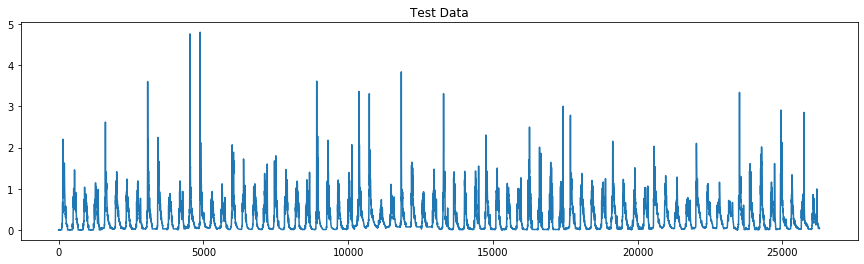

In [13]:
#visualize test dataset

plt.figure(figsize=(15,4))
plt.plot(y_test)
plt.title('Test Data')
plt.show()

In [0]:
# build model

#model = Sequential()
#model.add(LSTM(20, 
#               input_shape = (365,5), 
#               return_sequences = True,
#                #return_state = True,
#                kernel_regularizer = regularizers.l2(0.001)))
# model.add(Dropout(rate = 0.1))
# model.add(LSTM(20, 
#                input_shape = (365,5), 
#                return_sequences = True,
#                #return_state = True,
#                kernel_regularizer = regularizers.l2(0.001)))
# model.add(Flatten())
# model.add(Dense(1,
#                 activation = 'linear'))


# model.compile(loss = 'mse', 
#               optimizer=keras.optimizers.Adam(lr=0.005))
# model.summary()

# es = EarlyStopping(monitor='val_loss', 
#                    mode='min', 
#                    verbose=1, 
#                    patience = 5)

In [12]:
#build model

inputs = Input(shape = (365,5))
output_1, h1, c1 = LSTM(20, 
                     return_sequences = True,
                     return_state = True,
                     kernel_regularizer = regularizers.l2(0.001)
                     )(inputs)
output_2 = Dropout(rate = 0.1)(output_1)
output_3, h2, c2 = LSTM(20, 
                     return_sequences = True,
                     return_state = True,
                     kernel_regularizer = regularizers.l2(0.001)
                     )(output_2)
output_4 = Flatten()(output_3)
predictions = Dense(1, activation = 'linear')(output_4)
model = Model(input=inputs, outputs=predictions)

model.compile(loss = 'mse', 
              optimizer=keras.optimizers.Adam(lr=0.007))
model.summary()

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience = 5)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 365, 5)            0         
_________________________________________________________________
lstm_1 (LSTM)                [(None, 365, 20), (None,  2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 365, 20)           0         
_________________________________________________________________
lstm_2 (LSTM)                [(None, 365, 20), (None,  3280      
_________________________________________________________________
flatten_1 (Flatten)          (None, 7300)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7301      
Total params: 12,661
Trainable params: 12,661
Non-trainable params: 0
_______________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  app.launch_new_instance()


In [16]:
#train model

batch_size = 2048
epochs = 40
history = model.fit(x_train,y_train, 
                    validation_data = (x_valid, y_valid),
                    shuffle = True, 
                    epochs = epochs, 
                    batch_size = batch_size,
                    verbose = 1, 
                    callbacks = [es])

Train on 98658 samples, validate on 26280 samples
Epoch 1/40
98658/98658 [==============================] - 76s 768us/step - loss: 0.0941 - val_loss: 0.0711
Epoch 2/40
98658/98658 [==============================] - 77s 777us/step - loss: 0.0577 - val_loss: 0.0592
Epoch 3/40
98658/98658 [==============================] - 76s 775us/step - loss: 0.0492 - val_loss: 0.0536
Epoch 4/40
98658/98658 [==============================] - 76s 774us/step - loss: 0.0449 - val_loss: 0.0511
Epoch 5/40
98658/98658 [==============================] - 76s 775us/step - loss: 0.0417 - val_loss: 0.0490
Epoch 6/40
98658/98658 [==============================] - 76s 773us/step - loss: 0.0394 - val_loss: 0.0465
Epoch 7/40
98658/98658 [==============================] - 76s 770us/step - loss: 0.0375 - val_loss: 0.0444
Epoch 8/40
98658/98658 [==============================] - 76s 774us/step - loss: 0.0361 - val_loss: 0.0437
Epoch 9/40
98658/98658 [==============================] - 76s 773us/step - loss: 0.0347 - val_

In [0]:
#save model

saveModel = 0

if saveModel == 1:

  if glacierStations == 1:
    modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE_glacierStations_' + str(epochs) + '_epochs'
    model.save(modelName + '.h5')
  else:
    modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE_' + str(epochs) + '_epochs'
    model.save(modelName + '.h5')

In [0]:
#load model

loadModel = 0

if loadModel == 1:

  dataPath = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/'

  if glacierStations == 1:
    modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE_glacierStations_' + str(epochs) + '_epochs'
    model = load_model(dataPath + modelName + '.h5')
  else:
    modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE'
    model = load_model(dataPath + modelName + '.h5')

  model = load_model(dataPath + str(num_stations) + '_stations_LSTM_DO_LSTM_DENSE.h5')

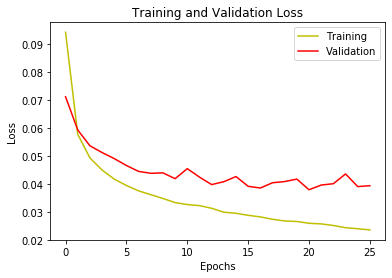

In [19]:
#plot loss

saveIt = 0

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(loss, 'y', label='Training')
plt.plot(val_loss, 'r', label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.xlim((1,10))
#plt.ylim((0,.1))
#plt.show()

if saveIt:
  plt.savefig('loss.png')

In [0]:
#predict streamflow with trained model

y_testPredict = model.predict_on_batch(x_test)


In [21]:
#compute NSE

window = 366
NSE = nse(y_test,y_testPredict)
NSE_rolling = nse_rolling(y_test, y_testPredict, window, stride = 365)

print('NSE = ' + str(NSE)[:4])

NSE = 0.74


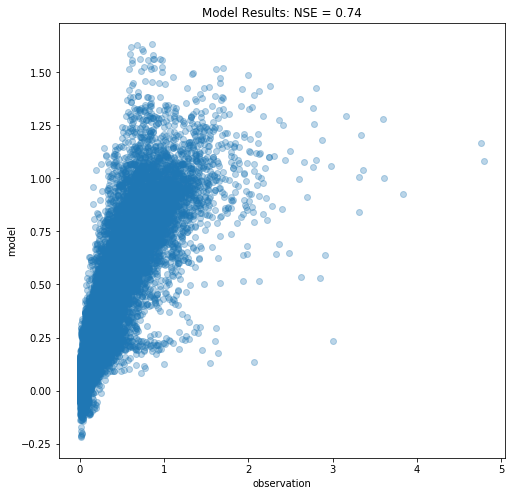

In [23]:
#plot model vs observed scatter plot

saveIt = 1

plt.figure(figsize = (8,8))

plt.scatter(y_test, y_testPredict, alpha = 0.3)
plt.xlabel('observation')
plt.ylabel('model')
plt.title('Model Results: NSE = ' + str(NSE)[:4])
#plt.xlim((0,4))

if saveIt:
  plt.savefig('obs_vs_model.png')

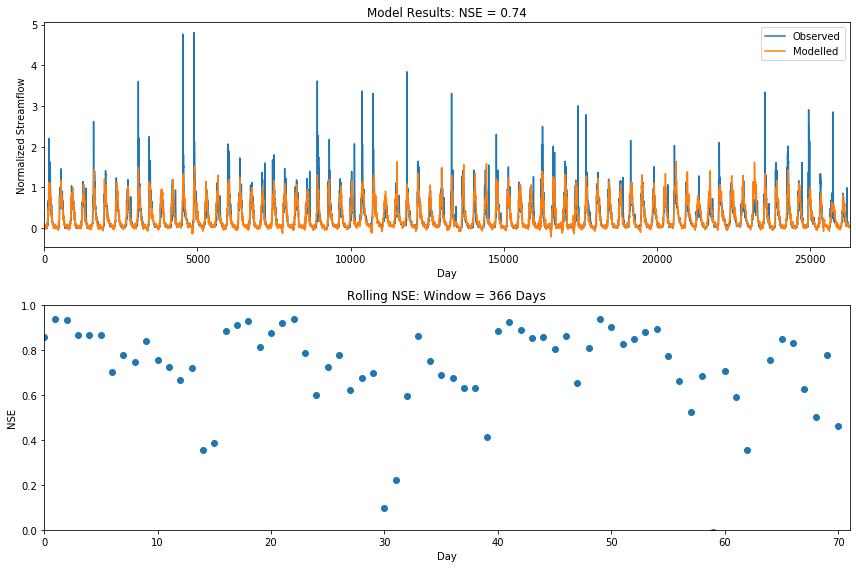

In [31]:
#plot time series of model and observations 

saveIt = 1

plt.figure(figsize = (12,8))
plt.subplot(2,1,1)
plt.plot(y_test, label = 'Observed')
plt.plot(y_testPredict, label = 'Modelled')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Normalized Streamflow')
plt.title('Model Results: NSE = ' + str(NSE)[:4])
plt.xlim((0,len(y_test)))
#plt.xlim((0,1500))
#plt.ylim((0,5))

plt.subplot(2,1,2)
#plt.plot(range(int(window/2),len(y_test)-int(window/2)),NSE_rolling)
plt.scatter(range(len(NSE_rolling)),NSE_rolling)
plt.ylim((0,1))
plt.xlim((0,len(NSE_rolling)))
plt.xlabel('Day')
plt.ylabel('NSE')
plt.title('Rolling NSE: Window = ' + str(window) + ' Days')

plt.tight_layout()

if saveIt:
  plt.savefig('modelled_time_series.png')

plt.show()

# Investigate performance in space and time

In [32]:
#what are the streamflow predictions at all stations?

dataPath = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/'

load_saved_predictions = 0
save_predictions = 0#1 - load_saved_predictions

if load_saved_predictions:
  pickle_in = open(dataPath + 'y_predict_' + str(num_stations) + '_stations.pickle','rb')
  y_predict = pickle.load(pickle_in)
elif not load_saved_predictions:
  #y_predict = model.predict(x)
  y_predict = model.predict(x, batch_size=2048, verbose = 1)

if save_predictions:
  pickle_out = open('y_predict_' + str(num_stations) + '_stations.pickle','wb')
  pickle.dump(y_predict,pickle_out)
  pickle_out.close()

151218/151218 [==============================] - 36s 237us/step


In [0]:
#what are the streamflow predictions at each station?

obs_per_station = int(len(x)/num_stations)
NSE_station = []
NSE_rolling_station = []

kk = 0
for station in range(num_stations):
  
  NSE = nse(y[kk : kk+obs_per_station], y_predict[kk : kk+obs_per_station])
  NSE_station.append(NSE)

  NSE_rolling = nse_rolling(y[kk : kk+obs_per_station], y_predict[kk : kk+obs_per_station], window = 366, stride = 365)
  NSE_rolling = np.asarray(NSE_rolling)
  thresh = 0
  indices = NSE_rolling < thresh
  NSE_rolling[indices] = 0
  NSE_rolling_station.append(NSE_rolling)

  kk += obs_per_station

NSE_rolling_station = np.asarray(NSE_rolling_station).T
#NSE_rolling_station[np.argwhere(NSE_rolling_station<0)] = 0

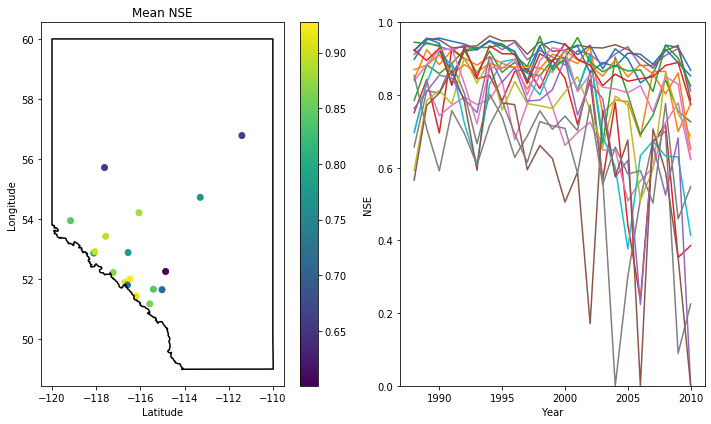

In [35]:
#visualize performance

saveIt = 0

plt.figure(figsize = (10,6))

plt.subplot(1,2,1)
#inds = stationsWithGlaciers[range(num_stations)]
#inds = [val for val in range(num_stations)]
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_station)
plot_AB()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Mean NSE')
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(range(1988,2011),NSE_rolling_station)
plt.xlabel('Year')
plt.ylabel('NSE')
plt.ylim((0,1))

plt.tight_layout()

if saveIt == 1:
  plt.savefig('meanNSE_and_series.png')

plt.show()

In [0]:
#cluster NSE time series
from sklearn.cluster import KMeans

data = NSE_rolling_station.T

n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters).fit(data)
labels = kmeans.labels_

#find mean pattern of each cluster
cluster_pattern = np.empty((n_clusters,np.shape(data)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(labels==cluster_num)
    cluster_pattern[cluster_num,:] = np.mean(data[inds,:],axis=0)
    
cluster_obs = np.empty((np.shape(data)))
for ind in range(len(data)):
    cluster_obs[ind] = cluster_pattern[labels[ind]]


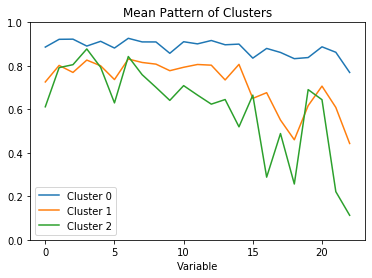

In [41]:
#visualize clusters

plt.plot(cluster_pattern.T)
plt.xlabel('Variable')
plt.title('Mean Pattern of Clusters')
plt.legend(['Cluster ' + str(ii) for ii in range(n_clusters)])
plt.ylim((0,1))
plt.show()

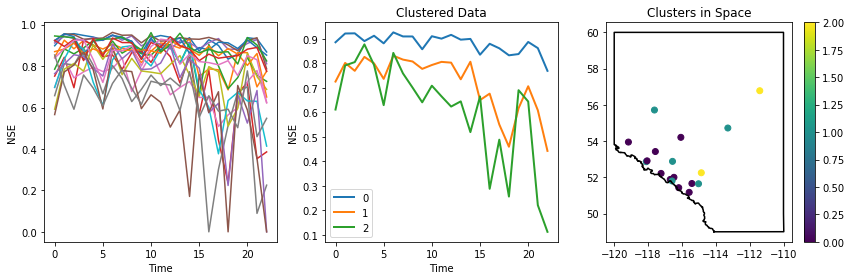

In [49]:
#visualize cluster results

saveIt = 0

inds = [val for val in range(num_stations)]
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(data.T)
plt.xlabel('Time')
plt.ylabel('NSE')
plt.title('Original Data')

plt.subplot(1,3,2)
plt.plot(cluster_pattern.T,linewidth=2)
plt.xlabel('Time')
plt.ylabel('NSE')
plt.title('Clustered Data')
plt.legend(['0','1','2'])

plt.subplot(1,3,3)
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = labels)
plot_AB()
plt.colorbar()
plt.title('Clusters in Space')

plt.tight_layout()

if saveIt == 1:
  plt.savefig('originalNSE_clusteredNSE_spatialClusters.png')

plt.show()

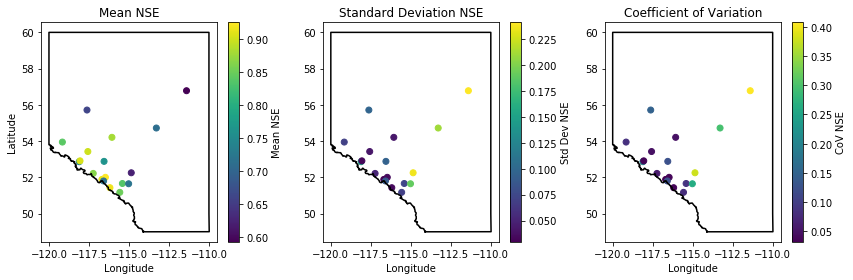

In [50]:
#plot mean NSE and variability of NSE

#inds = stationsWithGlaciers[range(num_stations)]

NSE_mean_stations = np.mean(NSE_rolling_station,axis=0)
NSE_std_stations = np.std(NSE_rolling_station,axis=0)
NSE_cov_stations = NSE_std_stations / NSE_mean_stations

plt.figure(figsize = (12,4))

plt.subplot(1,3,1)
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_mean_stations)
plot_AB()
#plt.scatter(stationLon[inds[-4:]],stationLat[inds[-4:]], marker = 's')
cbar = plt.colorbar()
cbar.set_label('Mean NSE')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mean NSE')

plt.subplot(1,3,2)
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_std_stations)
plot_AB()
cbar = plt.colorbar()
cbar.set_label('Std Dev NSE')
plt.xlabel('Longitude')
plt.title('Standard Deviation NSE')

plt.subplot(1,3,3)
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_cov_stations)
plot_AB()
cbar = plt.colorbar()
cbar.set_label('CoV NSE')
plt.xlabel('Longitude')
plt.title('Coefficient of Variation')

plt.tight_layout()
plt.show()

# Extract hidden and cell states

In [0]:
# compute cell states for each station on one day and cluster this data

# compute cell states
day_num = 160
layer_num = 0
ct_station = []
ht_station = []
jj = 0

for kk in stationInds:

  xs = x[day_num + jj]
  ct, ht = get_LSTM_states(model = model, layer_num = layer_num, xs = xs)
  ct_station.append( np.squeeze(np.reshape(ct,(1,-1))) )
  ht_station.append( np.squeeze(np.reshape(ht,(1,-1))) )

  jj += obs_per_station

#cluster
data = np.asarray(ct_station)
n_clusters = 4
kmeans = KMeans(n_clusters = n_clusters).fit(data)
labels = kmeans.labels_

#find mean pattern of each cluster
cluster_pattern = np.empty((n_clusters,np.shape(data)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(labels==cluster_num)
    cluster_pattern[cluster_num,:] = np.mean(data[inds,:],axis=0)
    
cluster_obs = np.empty((np.shape(data)))
for ind in range(len(data)):
    cluster_obs[ind] = cluster_pattern[labels[ind]]

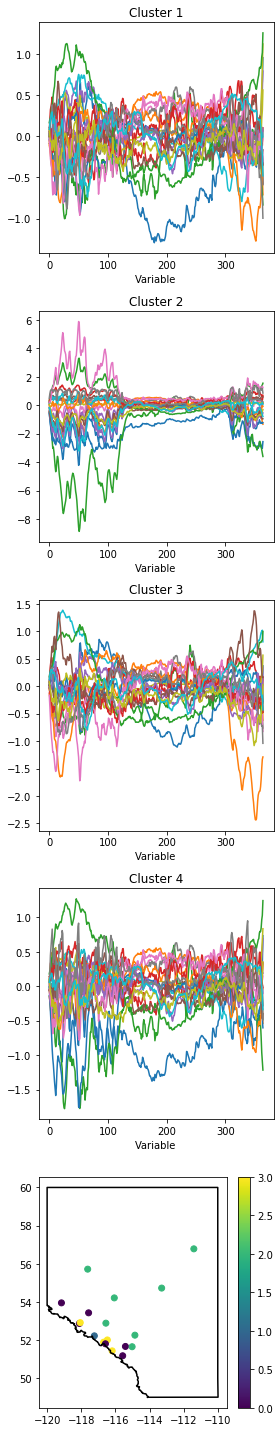

In [73]:
#visualize clusters

plt.figure(figsize = (4,(n_clusters + 1)*4))

for kk in range(n_clusters+1):
  plt.subplot(n_clusters+1,1,kk+1)
  if kk < n_clusters:
    plt.plot(np.reshape(cluster_pattern[kk],(365,20)))
    plt.xlabel('Variable')
    plt.title('Cluster ' + str(kk+1))
  else:
    plt.scatter(stationLon[stationInds],stationLat[stationInds], c = labels)
    plt.colorbar()
    plot_AB()

plt.tight_layout()
plt.show()

In [0]:
# compute cell states for each day at one station and cluster this data

# compute cell states
station_num = stationInds[0]
dayInds = range(365*5)
ct_day = []
ht_day = []
jj = 0

for kk in dayInds:

  if len(x) > obs_per_station:
    xs = x[station_num*obs_per_station + kk]
  else:
    xs = x[kk]
    
  ct, ht = get_LSTM_states(model = model, layer_num = 0, xs = xs)
  ct_day.append( np.squeeze(np.reshape(ct,(1,-1))) )
  ht_day.append( np.squeeze(np.reshape(ht,(1,-1))) )

#cluster
data = np.asarray(ct_day)
n_clusters = 4
kmeans = KMeans(n_clusters = n_clusters).fit(data)
labels = kmeans.labels_

#find mean pattern of each cluster
cluster_pattern = np.empty((n_clusters,np.shape(data)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(labels==cluster_num)
    cluster_pattern[cluster_num,:] = np.mean(data[inds,:],axis=0)
    
cluster_obs = np.empty((np.shape(data)))
for ind in range(len(data)):
    cluster_obs[ind] = cluster_pattern[labels[ind]]

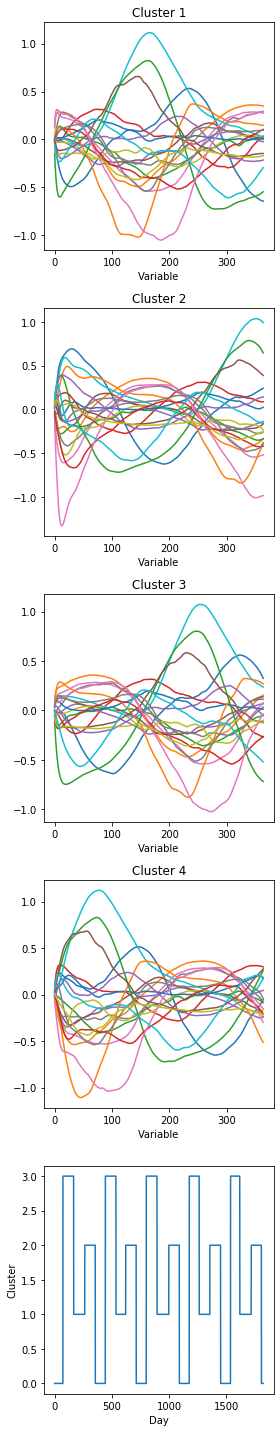

In [77]:
#visualize clusters

plt.figure(figsize = (4,(n_clusters + 1)*4))

for kk in range(n_clusters+1):
  plt.subplot(n_clusters+1,1,kk+1)
  if kk < n_clusters:
    plt.plot(np.reshape(cluster_pattern[kk],(365,20)))
    plt.xlabel('Variable')
    plt.title('Cluster ' + str(kk+1))
  else:
    plt.plot(labels)
    plt.xlabel('Day')
    plt.ylabel('Cluster')

plt.tight_layout()
plt.show()

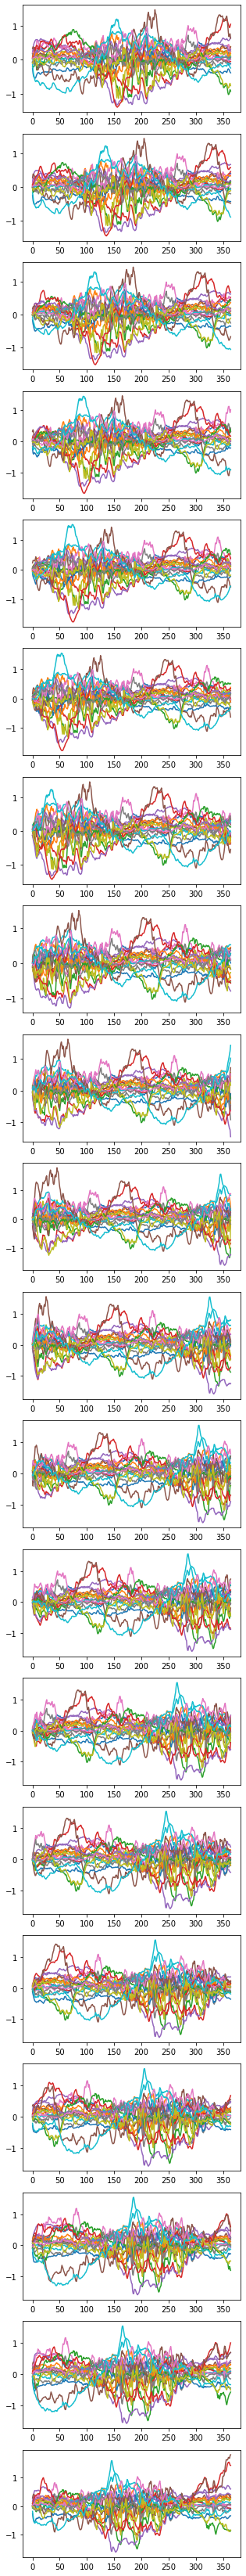

In [0]:
c_ts = []
h_ts = []

num_frames = 20
step = 20
start_frame = 0

for kk in range(start_frame, start_frame + step*num_frames, step):

  xs = x[kk]

  c_t, h_t = get_LSTM_states(model = model, layer_num = 0, xs = xs)
  c_ts.append(c_t)
  h_ts.append(h_t)

plt.figure(figsize = (5,num_frames*3))

for kk in range(num_frames):
  
  plt.subplot(num_frames,1,kk+1)  
  plt.plot(c_ts[kk])

plt.show()

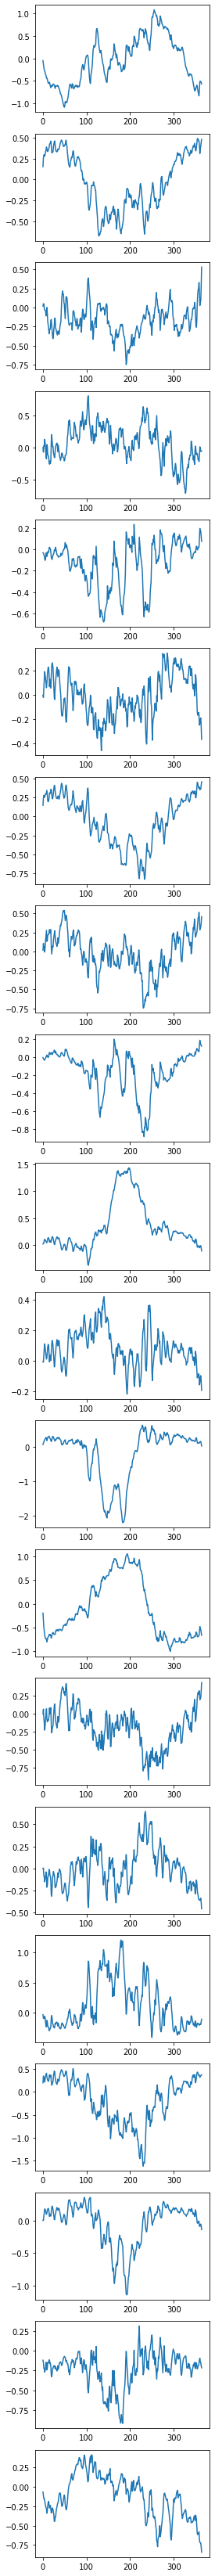

In [78]:
units = 20
plt.figure(figsize = (4, units*3))

for kk in range(units):
  plt.subplot(units, 1, kk+1)
  plt.plot(np.asarray(ct)[:,kk])

# Fine tuning on one station

In [0]:
#create input/output datasets

station_fine_tune = 4

num_obs = (len(eraDays) - 365) #len(stationsWithGlaciers)

x = np.empty((num_obs,365,5))
y = np.empty((num_obs))

jj = 0
   
for day in range(len(eraDays)-365): #for each day of flow
    
    x[jj,:,0] = stationT[station_fine_tune,day:day+365]
    x[jj,:,1] = stationP[station_fine_tune,day:day+365]
    x[jj,:,2] = stationH[station_fine_tune,day:day+365]
    x[jj,:,3] = stationS[station_fine_tune,day:day+365]
    x[jj,:,4] = stationM[station_fine_tune,day:day+365]
    y[jj] = F[day+365,station_fine_tune]
    jj+=1

In [0]:
#split into train/test
fracTrain = 0.8
Ntrain = int(fracTrain * len(x))
test_years = 5
Ntrain = int((23 - test_years)*365)

x_train = x[:Ntrain]
y_train = y[:Ntrain]

x_test = x[Ntrain:]
y_test = y[Ntrain:]

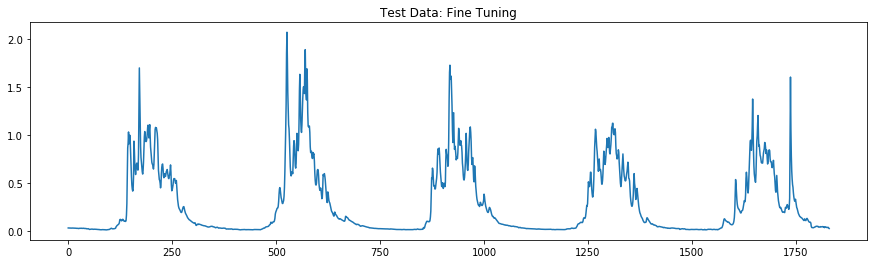

In [16]:
#visualize test data

plt.figure(figsize=(15,4))
plt.plot(y_test)
plt.title('Test Data: Fine Tuning')
plt.show()

In [17]:
#load model

loadModel = 1

if loadModel == 1:
  model = load_model('18_stations_LSTM_DO_LSTM_DENSE_glacierStations_40_epochs.h5')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [18]:
#train model

model.compile(loss = 'mse', 
              optimizer=keras.optimizers.Adam(lr=0.0001))

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience = 2)

batch_size = 256
epochs = 20
history = model.fit(x_train,y_train, 
                    validation_split = 0.2, 
                    epochs = epochs, 
                    batch_size = batch_size,
                    verbose = 1, 
                    callbacks = [es])

Train on 5256 samples, validate on 1314 samples
Epoch 1/20
5256/5256 [==============================] - 26s 5ms/step - loss: 0.0099 - val_loss: 0.0147
Epoch 2/20
5256/5256 [==============================] - 23s 4ms/step - loss: 0.0088 - val_loss: 0.0146
Epoch 3/20
5256/5256 [==============================] - 24s 5ms/step - loss: 0.0084 - val_loss: 0.0145
Epoch 4/20
5256/5256 [==============================] - 23s 4ms/step - loss: 0.0081 - val_loss: 0.0143
Epoch 5/20
5256/5256 [==============================] - 24s 5ms/step - loss: 0.0079 - val_loss: 0.0147
Epoch 6/20
5256/5256 [==============================] - 24s 5ms/step - loss: 0.0078 - val_loss: 0.0148
Epoch 00006: early stopping


In [0]:
#save model

saveModel = 1

if saveModel == 1:

  if glacierStations == 1:
    modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE_glacierStations_' + str(epochs) + '_epochs_fine_tune'
    model.save(modelName + '.h5')
  else:
    modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE_' + str(epochs) + '_epochs_fine_tune'
    model.save(modelName + '.h5')

In [0]:
#load model

loadModel = 0

if loadModel == 1:

  dataPath = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/'

  if glacierStations == 1:
    modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE_glacierStations_' + str(epochs) + '_epochs_fine_tune'
    model = load_model(dataPath + modelName + '.h5')
  else:
    modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE'
    model = load_model(dataPath + modelName + '.h5')

  #model = load_model(dataPath + str(num_stations) + '_stations_LSTM_DO_LSTM_DENSE.h5')

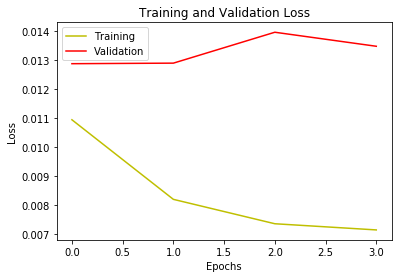

In [104]:
saveIt = 0

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(loss, 'y', label='Training')
plt.plot(val_loss, 'r', label='Validation')
plt.title('Training and Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.ylim((0,1))
#plt.show()

if saveIt:
  plt.savefig('loss.png')

In [0]:
#predict streamflow with trained model
#y_trainPredict = model.predict(x_train)
y_testPredict = model.predict_on_batch(x_test)

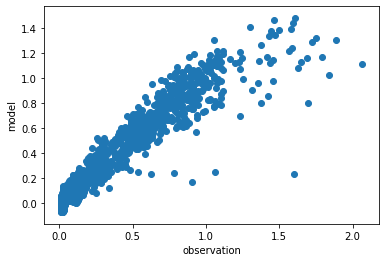

In [106]:
#visualize

saveIt = 0

plt.scatter(y_test,y_testPredict)
plt.xlabel('observation')
plt.ylabel('model')

if saveIt:
  plt.savefig('obs_vs_model.png')

In [107]:
#compute NSE

window = 366
stride = 365
NSE = nse(y_test,y_testPredict)
NSE_rolling = nse_rolling(y_test, y_testPredict, window = window, stride = stride)
print('NSE = ' + str(NSE)[:4])

NSE = 0.91


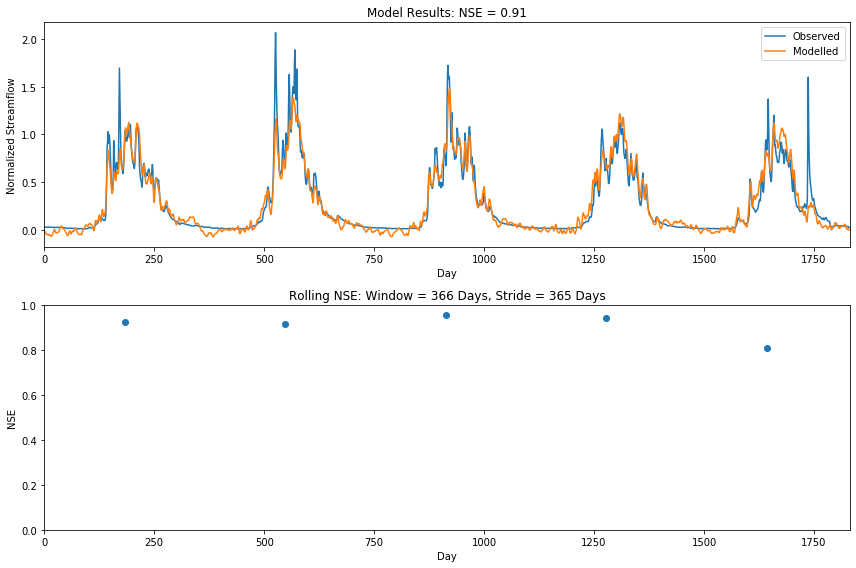

In [108]:
#visualize more

saveIt = 0

plt.figure(figsize = (12,8))

plt.subplot(2,1,1)
plt.plot(y_test, label = 'Observed')
plt.plot(y_testPredict, label = 'Modelled')
#plt.xlim((4500,6000))
plt.legend()
plt.xlabel('Day')
plt.ylabel('Normalized Streamflow')
plt.xlim((0,len(y_test)))
plt.title('Model Results: NSE = ' + str(NSE)[:4])

plt.subplot(2,1,2)
plt.scatter(range(int(window/2),len(y_test)-int(window/2), stride),NSE_rolling)
#plt.plot(NSE_rolling)
plt.ylim((0,1))
plt.xlim((0,len(y_test)))
plt.xlabel('Day')
plt.ylabel('NSE')
plt.title('Rolling NSE: Window = ' + str(window) + ' Days, Stride = ' + str(stride) + ' Days')

plt.tight_layout()

if saveIt:
  plt.savefig('modelled_time_series.png')

plt.show()

# What is the model learning?

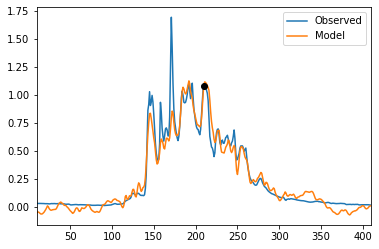

In [115]:
day = 210
plt.plot(y_test[:day + 200])
plt.plot(y_testPredict[:day + 200])
plt.scatter(day,y_test[day],c = 'k',zOrder = 3)
plt.xlim((day - 200, day + 200))
plt.legend(('Observed','Model'))

plt.show()

In [0]:
iters = 5000
n = 100
p_1 = 0.9

def get_heat(model, iters, x_test, y_test, day, n, p_1):

  #start = time.process_time()

  x_int = np.arange(0,365 + int(365/n), int(365/n))
  y_int = np.arange(0,5)
  m = len(x_int)
  xnew = [val for val in range(365)]

  xday = np.reshape(x_test[day],(1,365,5))

  mask_small = np.random.choice([0,1],size = (iters,1,m,5), p = [1-p_1,p_1])
  mask_large = [np.reshape(np.transpose(interpolate.interp2d(x_int,y_int,mask_small[iter])(xnew,y_int)),(1,365,5)) for iter in range(iters)]

  #print(time.process_time() - start)

  xday_mask = np.squeeze(xday * mask_large)
  x_all = np.concatenate((xday,xday_mask))
  y_all = model.predict_on_batch(x_all)
  yday = y_all[0]
  yday_mask = y_all[1:]

  #print(time.process_time() - start)

  delta = [np.ones(np.shape(mask_large[0])) * np.squeeze(np.abs(yday - yday_mask[iter])) for iter in range(iters)]
  
  #print(time.process_time() - start, time_per_day)

  heat_iters = np.asarray(delta) * (1 - np.asarray(mask_large))
  heat = np.transpose(np.mean(np.squeeze(heat_iters), axis=0))

  #print(time.process_time() - start)

  return heat


In [0]:
heat = get_heat(model,iters,x_test,y_test,day,n,p_1)

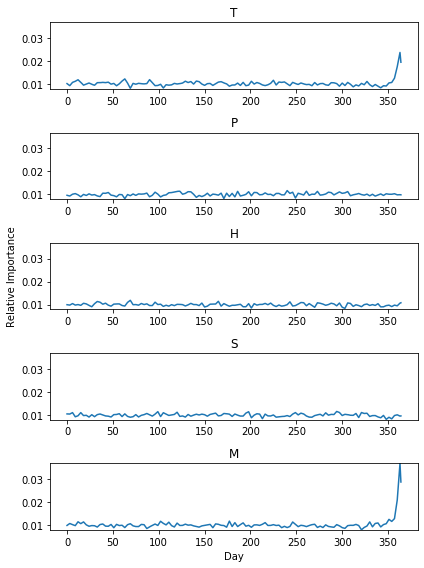

In [122]:
#visualize heatmap

ys = ['T','P','H','S','M']

plt.figure(figsize = (6,8))

for var in range(5):
  plt.subplot(5,1,var+1)
  plt.plot(heat[var])
  plt.title(ys[var])
  if var == 4:
    plt.xlabel('Day')
  if var == 2:
    plt.ylabel('Relative Importance')
  plt.ylim((np.min(heat),np.max(heat)))

#plt.subplot(111)
#plt.plot(np.squeeze(heat))
#plt.xlabel('Days before flow')
#plt.ylabel('Relative importance')
plt.tight_layout()
plt.show()

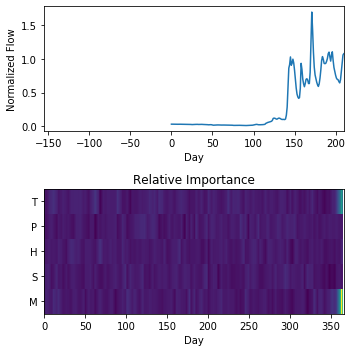

In [129]:
plt.figure(figsize=(5,5))

plt.subplot(2,1,1)
plt.plot(y_test[:day+1])
plt.xlim((day-365,day))
plt.xlabel('Day')
plt.ylabel('Normalized Flow')

ax = plt.subplot(2,1,2)
plt.imshow(np.squeeze(heat),aspect='auto')
plt.xlim((0,366))
plt.xlabel('Day')
plt.title('Relative Importance')
ax.set_yticklabels(['','T','P','H','S','M'])

plt.tight_layout()
plt.show()

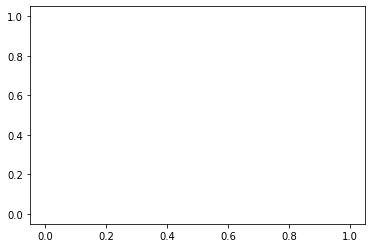

In [127]:
plt.plot(y_test[day-365:day+1])

In [99]:
#make heatmaps for full year, and cluster

import time

days = range(365)
#heat_vec = np.ones((len(days),365,5))
iters = 1000

start = time.process_time()

heat_vec = [get_heat(model, iters, x_test, y_test, day, n, p_1) for day in days]
#get_heat(model, iters, x_test, y_test, day, n, p_1)
time_per_day = (time.process_time() - start)/len(days)
print(time.process_time() - start, time_per_day)

291.45546557500006 0.798507953169863


In [0]:
#cluster

data = np.reshape(heat,(len(days),365*5))
n_clusters = 8
kmeans = KMeans(n_clusters = n_clusters).fit(data)
labels = kmeans.labels_

#find mean pattern of each cluster
cluster_pattern = np.empty((n_clusters,np.shape(data)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(labels==cluster_num)
    cluster_pattern[cluster_num,:] = np.mean(data[inds,:],axis=0)
    
cluster_obs = np.empty((np.shape(data)))
for ind in range(len(data)):
    cluster_obs[ind] = cluster_pattern[labels[ind]]

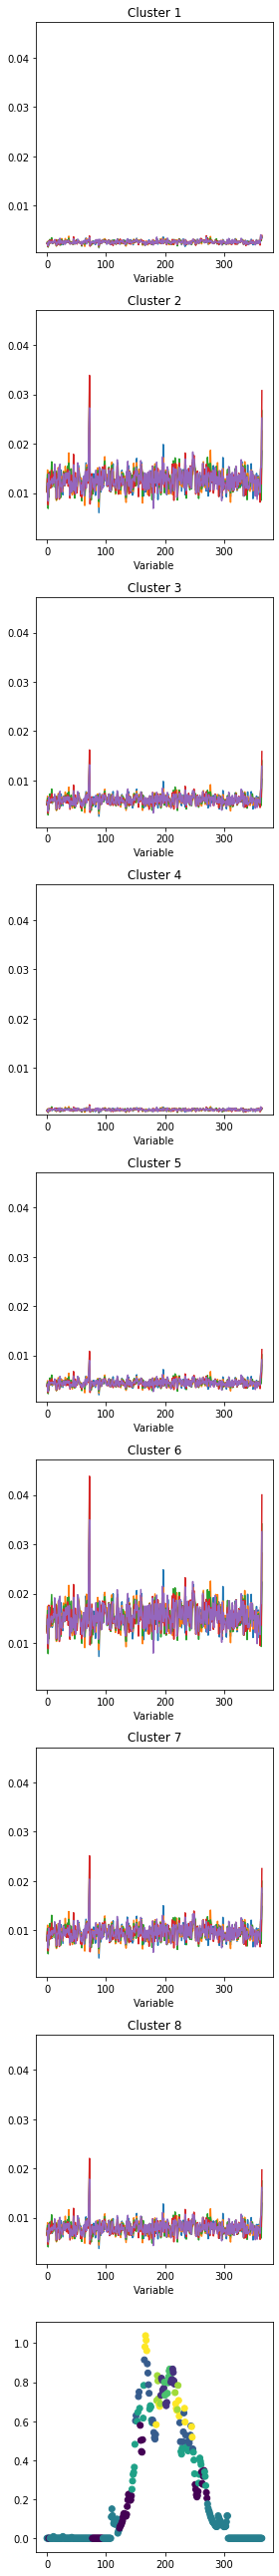

In [86]:
#visualize clusters

plt.figure(figsize = (4,(n_clusters + 1)*4))

for kk in range(n_clusters+1):
  plt.subplot(n_clusters+1,1,kk+1)
  if kk < n_clusters:
    plt.plot(np.reshape(cluster_pattern[kk],(365,5)))
    plt.xlabel('Variable')
    plt.title('Cluster ' + str(kk+1))
    plt.ylim((np.min(heat),np.max(heat)))
  else:
    #plt.plot(labels)
    plt.scatter(range(365),y_test[:365], c=labels)

plt.tight_layout()
plt.show()

# Removing glacier melt

In [0]:
load_model = 0
if load_model == 1:
  model = load_model('/content/18_stations_LSTM_DO_LSTM_DENSE_glacierStations_40_epochs.h5')

In [0]:
y_testPredict = model.predict_on_batch(x_test)

In [0]:
x_test_noMelt = np.copy(x_test)
x_test_noMelt[:,:,4] = np.ones(np.shape(x_test_noMelt[:,:,4])) * x_test[0,0,4]


In [0]:
y_testPredict_noMelt = model.predict_on_batch(x_test_noMelt)

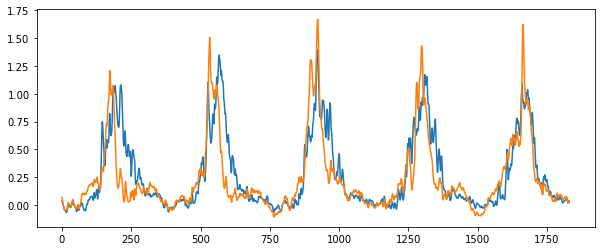

In [32]:
plt.figure(figsize = (10,4))
plt.plot(y_testPredict)
plt.plot(y_testPredict_noMelt)
plt.show()

# Garbage Bin

In [0]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
import scipy
#def create_mask(h = 1, w = 10, H = 5, W = 365, p_1 = 0.7):

h = 2
w = 10
H = 5
W = 365
p_1 = 0.7

mask_small = np.random.choice([0,1], size = (h,w), p = [1-p_1, p_1])
x1 = [val for val in range(w)]
y1 = [val for val in range(h)]
x2 = [val * (w/W) for val in range(W)]
y2 = [val * (h/H) for val in range(H)]
f = scipy.interpolate.interp2d(x1,y1,mask_small,kind = 'linear')
mask_large = f(x2,y2,mask_small)

#return mask_small, mask_large

#mask_small, mask = create_mask()
plt.imshow(mask_large)


ValueError: ignored

In [0]:
mask_large

In [0]:
# create a random mask
def create_mask(h=7, w=7, H=224, W=224, p_1=0.5, resample=Image.BILINEAR):

    # create random hxw mask
    mask = np.random.choice([0, 1], size=(h, w), p=[1 - p_1, p_1])

    # resize
    mask = Image.fromarray(mask * 255.)
    mask = mask.resize((H + h, W + w), resample=resample)
    mask = np.array(mask)

    # crop to HxW
    w_crop = np.random.randint(0, w + 1)
    h_crop = np.random.randint(0, h + 1)
    mask = mask[h_crop:H + h_crop, w_crop:W + w_crop]

    # normalize
    mask /= np.max(mask)

    return mask

In [0]:
window = 90
NSE_rolling = nse_rolling(y_test, y_testPredict, window=window)

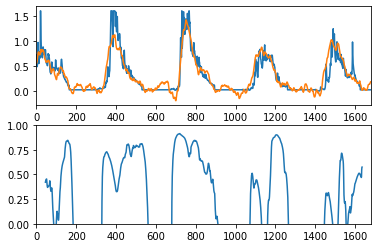

In [0]:
plt.subplot(2,1,1)
plt.plot(y_test)
plt.plot(y_testPredict)
plt.xlim((0,len(y_test)))

plt.subplot(2,1,2)
plt.plot(range(int(window/2),len(y_test)-int(window/2)),NSE_rolling)
plt.ylim((0,1))
plt.xlim((0,len(y_test)))

plt.show()

In [0]:
len(NSE_rolling)

1591

In [0]:
len(y_test)

1681

In [0]:
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

In [0]:
def perturb_prediction(i, model,day, xday, yday, n, p_1):
  
  x_ints = [val for val in range(0,365 + int(365/n),int(365/n))]
  y_ints = [val for val in range(5)]
  m = len(x_ints)

  mask_small = np.random.choice([0,1], size = (1,m,5), p = [1-p_1,p_1])

  f = interpolate.interp2d(x_ints,y_ints,mask_small)
  xnew = [val for val in range(0,365)]
  mask_large = np.reshape(np.transpose(f(xnew,y_ints)),(1,365,5))

  xday_mask = xday * mask_large
  yday_mask = model.predict(xday_mask)

  delta = np.abs(yday - yday_mask)
  heat = delta * (1 - mask_large)

  return heat

In [0]:
num_cores = multiprocessing.cpu_count()
iters = 500
n = 100
p_1 = 0.9
heat = np.zeros((1,365,5))

xday = np.reshape(x_test[day],(1,365,5))
yday = model.predict(xday)


In [0]:
inputs = tqdm([val for val in range(iters)])
processed_list = Parallel(n_jobs=num_cores)(delayed(perturb_prediction)(i,model, day, xday, yday, n, p_1) for i in inputs)


  4%|▍         | 20/500 [00:29<11:53,  1.49s/it]/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning

 15%|█▌        | 76/500 [02:08<11:50,  1.68s/it]

KeyboardInterrupt: ignored

In [0]:
heat_mean = np.mean(np.squeeze(processed_list), axis=0)

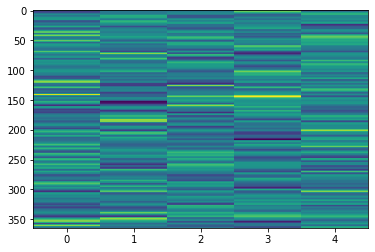

In [0]:
plt.imshow(heat_mean, aspect='auto')

In [0]:
iters = 500
n = 100
p_1 = 0.9


days = [val for val in range(365)]

start = time.process_time()

x_int = np.arange(0,365 + int(365/n), int(365/n))
y_int = np.arange(0,5)
m = len(x_int)
xnew = [val for val in range(365)]

xday = np.reshape(x_test[days],(len(days),1,365,5))

xday_iters = [np.repeat(xday[day,:,:,:],iters,axis=0) for day in days]
xday_iters = np.reshape(xday_iters,(len(days)*iters,1,365,5))

mask_small = np.random.choice([0,1],size = (iters,1,m,5), p = [1-p_1,p_1])
mask_large = [np.reshape(np.transpose(interpolate.interp2d(x_int,y_int,mask_small[iter])(xnew,y_int)),(1,365,5)) for iter in range(iters)]

#print(time.process_time() - start)

#xday_mask = np.squeeze(xday * mask_large)
xday_iters_mask = [xday_iters[jj:jj+iters] * mask_large for jj in np.arange(0,len(days)*iters,iters)]
xday_iters_mask = np.reshape(xday_iters_mask,(len(days)*iters,1,365,5))
x_all = np.squeeze(np.concatenate((xday,xday_iters_mask)))
y_all = model.predict(x_all, batch_size = 40000, verbose = 1)
yday = y_all[:len(days)]
yday_mask = y_all[len(days):]

#print(time.process_time() - start)
ydiffs = np.reshape([yday[jj] - yday_mask[jj*iters:jj*iters + iters] for jj in range(len(days))],(-1,1))
delta = [np.ones(np.shape(mask_large[0])) * np.squeeze(np.abs(ydiffs[kk])) for kk in range(len(ydiffs))]

#print(time.process_time() - start, time_per_day)

#heat_iters = np.asarray(delta) * (1 - np.asarray(mask_large))
heat_iters = [np.asarray(delta[jj*iters:(jj+1)*iters]) * (1 - np.asarray(mask_large)) for jj in range(len(days))]
heat_iters = np.reshape(heat_iters,(len(days)*iters,365,5))
heat = [np.mean(heat_iters[jj*iters : (jj+1)*iters], axis=0) for jj in range(len(days))]
heat = [np.transpose(heat[kk]) for kk in range(len(days))]

#print(time.process_time() - start)

print(time.process_time() - start, (time.process_time() - start)/len(days))



In [76]:
heat = np.transpose(heat)
np.shape(heat)

(365, 365, 5)

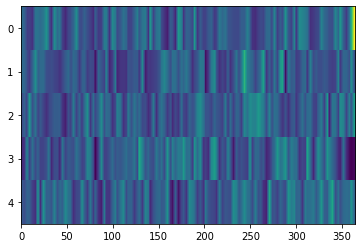

In [82]:
plt.imshow(np.squeeze(heats[0]),aspect='auto')

In [62]:
np.shape(mask_large)

(500, 1, 365, 5)

In [0]:
heat_iters = [np.asarray(delta[jj*iters:(jj+1)*iters]) * (1 - np.asarray(mask_large)) for jj in range(len(days))]
heat_iters = np.reshape(heat_iters,(len(days)*iters,365,5))

In [52]:
jj = 0
[np.shape(yday[jj] - yday_mask[jj*iters:jj*iters+iters]) for jj in range(len(days))]

[(500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),
 (500, 1),

In [0]:
xday_iters_mask = [xday_iters[jj:jj+iters] * mask_large for jj in np.arange(0,len(days)*iters,iters)]

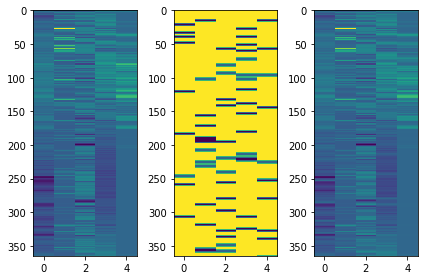

In [43]:
kk = 100000

plt.subplot(1,3,1)
plt.imshow(np.squeeze(xday_iters[kk]),aspect='auto')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(mask_large[int(kk/1000)]),aspect='auto')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(a[kk]),aspect='auto')

plt.tight_layout()
plt.show()

In [23]:
np.shape(xday)

(366, 1, 365, 5)

In [1]:
a = xday[0]
b = np.repeat(a[np.newaxis,:,:,:,],iters,axis=0)

xday_iters = [np.repeat(xday[day,:,:,:],iters,axis=0) for day in days]
xday_iters = np.reshape(xday_iters,(len(days)*iters,1,365,5))

NameError: ignored

In [0]:
c = np.reshape(xday_iters,(366000,1,365,5))

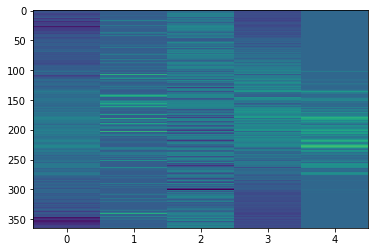

In [35]:
plt.imshow(np.squeeze(c[0]),aspect='auto')

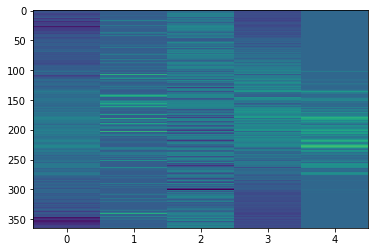

In [36]:
plt.imshow(np.squeeze(c[1]),aspect='auto')